In [1]:
import time
import string
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from collections import Counter
from scipy.sparse import hstack

import matplotlib.pyplot as plt
import seaborn as sns

from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning

from sklearn.metrics import average_precision_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

from hyperopt import hp, tpe
from hyperopt.fmin import fmin

# Preprocessing

In [2]:
with open('train.txt') as f:
    data = [s.replace('__label__', '').split('\t') for s in f.readlines()]

In [3]:
Counter(np.array([len(s)-2 for s in data]))

Counter({1: 143787, 2: 4877, 3: 111})

In [4]:
labels = []
[labels.extend(s[1:-1]) for s in data]

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

In [5]:
Counter(labels)

Counter({'THREAT': 7164, 'NORMAL': 122194, 'INSULT': 21952, 'OBSCENITY': 2564})

In [6]:
# XY = pd.DataFrame(columns = ['id', 'text', 'exclamation_num', 'question_num',
#                              'normal', 'threat', 'insult', 'obscenity'])
# XY['id'] = [s[0] for s in data]
# XY['text'] = [s[-1].strip() for s in data]
# XY['text_stemmed'] = stem_words(XY['text'])
# XY['text_lemmatised'] = lemmatise_words(XY['text']) # 9min 18s
# XY['exclamation_num'] = XY.text.str.count('!')
# XY['question_num'] = XY.text.str.count('\?')
# XY['stars_num'] = XY.text.str.count('.')

# statuses = pd.DataFrame([s[1:-1] for s in data])
# XY.normal = np.sum(np.where(statuses.values == 'NORMAL', 1, 0), axis = 1)
# XY.threat = np.sum(np.where(statuses.values == 'THREAT', 1, 0), axis = 1)
# XY.insult = np.sum(np.where(statuses.values == 'INSULT', 1, 0), axis = 1)
# XY.obscenity = np.sum(np.where(statuses.values == 'OBSCENITY', 1, 0), axis = 1)

# EDA

In [11]:
XY.loc[XY.normal == 1, 'threat':'obscenity'].sum()

threat       0
insult       0
obscenity    0
dtype: int64

In [12]:
# fig, ax = plt.subplots(1, 2, figsize = (15, 4))
# sns.distplot(XY.loc[(XY.threat == 1)].exclamation_num, 
#              kde = False, color = 'r', ax = ax[0])
# sns.distplot(XY.loc[(XY.threat == 0)].exclamation_num, 
#              kde = False, color = 'b', ax = ax[1])
# plt.show()

In [13]:
XY.loc[(XY.threat == 1)].exclamation_num.mean(), XY.loc[(XY.threat == 0)].exclamation_num.mean()

(0.871998883305416, 0.6199306551044763)

In [14]:
# fig, ax = plt.subplots(1, 2, figsize = (15, 4))
# sns.distplot(XY.loc[(XY.threat == 1)].question_num, 
#              kde = False, color = 'r', ax = ax[0])
# sns.distplot(XY.loc[(XY.threat == 0)].question_num, 
#              kde = False, color = 'b', ax = ax[1])
# plt.show()

In [15]:
XY.loc[(XY.threat == 1)].question_num.mean(), XY.loc[(XY.threat == 0)].question_num.mean()

(0.08458961474036851, 0.23243250877403593)

In [16]:
XY_train, XY_test = train_test_split(XY, test_size = 0.3, shuffle = True, random_state = 42)
XY_train.reset_index(drop = True, inplace = True)
XY_test.reset_index(drop = True, inplace = True)

In [17]:
XY_train.loc[:, 'normal':'obscenity'].mean(axis = 0) - XY_test.loc[:, 'normal':'obscenity'].mean(axis = 0) 

normal       0.001908
threat      -0.000569
insult      -0.002059
obscenity   -0.000665
dtype: float64

In [18]:
for i, row in XY_train.loc[XY_train.normal == 1].iloc[[10, 100, 1000]].iterrows():
    print(row.text)
    print()

дебил, скрывать нечего это только в ваших фантазиях!

господи,такая молодая!!!

всем добрый день.приглашаю азартных желающих именно побеждать игроков в забавы.сейчас лига розовая ускоряем любим побеждать.задания 320/400 +доп есть вопросы пишите в личку.



In [19]:
for i, row in XY_train.loc[XY_train.threat == 1].iloc[[10, 100, 1000]].iterrows():
    print(row.text)
    print()

сдохни тварь).это какое сердце нужно иметь, чтобы сиотреть в глаза этому песику несчастному.я просто плачу.:(

ублюдки, долбанутые, привязать за яйца и так же протащить.

всех этих сук к стенке, всех, всех, всех



In [20]:
for i, row in XY_train.loc[XY_train.insult == 1].iloc[[10, 100, 1000]].iterrows():
    print(row.text)
    print()

на кусочки этого козла разорвать.

давно пора, уебок достал. 🤬🤬🤬

а унас сми все пиздуны всё вокруг одно враньё жульё еврейское так что лучше мы жить не будем



In [21]:
for i, row in XY_train.loc[XY_train.obscenity == 1].iloc[[10, 100, 1000]].iterrows():
    print(row.text)
    print()

у анальной сучки походу седня окончательно крышу снесло#u62b889dffds#ты тока глянь какую пургу она несет#u622dfc4586s# #u888b947ff8s#

ятвоюмаму ебал когда она еще была внутри бабушки гиsоvаснги

хуйло дырявое, губы вытянул, отсосать хояет.



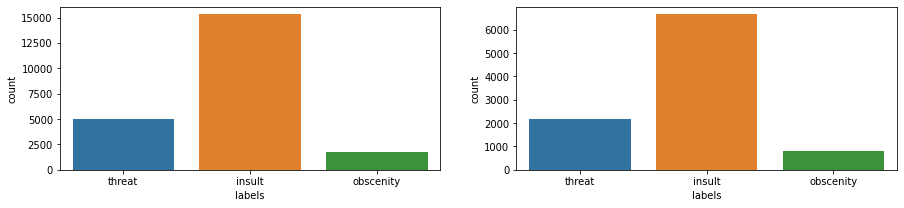

In [22]:
fig, ax = plt.subplots(1, 2, figsize = (15, 3))
sns.barplot(data = XY_train.loc[:, 'threat':'obscenity'].sum().reset_index().rename(columns = \
            {0: 'count', 'index': 'labels'}), x = 'labels', y = 'count', ax = ax[0])
sns.barplot(data = XY_test.loc[:, 'threat':'obscenity'].sum().reset_index().rename(columns = \
            {0: 'count', 'index': 'labels'}), x = 'labels', y = 'count', ax = ax[1])
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation = 0)
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation = 0)
plt.show()

In [23]:
# fig, ax = plt.subplots(1, 1, figsize = (12, 5))
# crosses = dict(Counter(XY_abn.threat.astype('str') + XY_abn.insult.astype('str') + XY_abn.obscenity.astype('str')))
# sns.barplot(x = list(crosses.keys()), y = list(crosses.values()))
# plt.show()

In [24]:
# XY_abn.groupby('threat').agg({'insult': np.mean, 'obscenity': np.mean})
# XY_abn.groupby('insult').agg({'threat': np.mean, 'obscenity': np.mean})
# XY_abn.groupby('obscenity').agg({'threat': np.mean, 'insult': np.mean})

# XY_abn.groupby(['insult', 'threat']).agg({'obscenity': np.mean})
# XY_abn.groupby(['insult', 'obscenity']).agg({'threat': np.mean})
# XY_abn.groupby(['threat', 'obscenity']).agg({'insult': np.mean})

In [25]:
XY_train['text'].str.findall(r'[A-Z]').str.len().sum()

0

# Label predictions
## Function manufacture

In [26]:
def stem_words(text, stemmer = SnowballStemmer("russian", ignore_stopwords = True)):
    clean_sents = [s.translate(str.maketrans('', '', string.punctuation)) for s in text.tolist()]
    list_of_sent_lists = [sent.split(' ') for sent in clean_sents]
    
    new_stemmed_sentences = []
    for sent_list in list_of_sent_lists:
        new_stemmed_sentences.append(' '.join([stemmer.stem(word) for word in sent_list]))
    
    return new_stemmed_sentences

In [27]:
XY_train['text_stemmed'] = stem_words(XY_train['text'])
XY_test['text_stemmed'] = stem_words(XY_test['text'])

<ipython-input-27-beb1e0106e9c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  XY_train['text_stemmed'] = stem_words(XY_train['text'])
<ipython-input-27-beb1e0106e9c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  XY_test['text_stemmed'] = stem_words(XY_test['text'])


In [28]:
XY_train.loc[:, ['text', 'text_stemmed']].head()

,text,text_stemmed
0,можно тел,можно тел
1,"надейся только на себя,упал вставай и дальше и...",над только на себяупа встава и дальш идиникт т...
2,может перезагрузить надо было,может перезагруз надо было
3,интересно что они курят перед заседаниями(h),интересн что они кур перед заседаниямиh
4,"не знаю где вас на дружбе,а у нас на ломоносов...",не зна где вас на дружбе у нас на ломоносов со...


In [29]:
stopWords = stopwords.words('russian')

In [60]:
@ignore_warnings(category=ConvergenceWarning)
def search_best_tfidf_and_algo(X, y, algo = 'logit', ns = 3, num_of_evals = 10):
    
    def hyperopt_tfidf_algo_score(params):
        try:
            transf = TfidfVectorizer(stop_words = params['stop_words'], ngram_range = (1, params['ngram_range']),
                                     min_df = params['min_df'], max_df = params['max_df'])

            X_prep = transf.fit_transform(X.text_stemmed) if params['stemming'] else transf.fit_transform(X.text)

            extra = ['exclamation_num', 'question_num']
            X_prep = hstack([X_prep, X.loc[:, extra].values]) if params['activate_s'] else X_prep

            algo_params = {key: value for key, value in params.items() if key not in ['stop_words', 'ngram_range', 
                                                                                      'stemming', 'activate_s',
                                                                                      'min_df']}
            if algo == 'logit':
                clf = LogisticRegression(**algo_params, class_weight = 'balanced')
            elif algo == 'xgb':
                clf = XGBClassifier(objective = 'binary:logistic', **algo_params)

            current_score_scores = cross_val_score(clf, X_prep, y, cv = StratifiedKFold(n_splits = ns),
                                                   scoring = 'average_precision')
            
            mean_score = np.mean(current_score_scores)
            current_score = mean_score if np.std(current_score_scores * 100) < 1.25 else mean_score / 1.25
            
        except:
            current_score = 0
            print(f"Bad: {algo_params['min_df'], algo_params['max_df']}")
        
        return -current_score
        
    space_tfidf = {
        'stop_words': hp.choice('stop_words', [stopWords, None]),
        'stemming': hp.choice('stemming', [True, False]),
        'ngram_range': hp.choice('ngram_range', [1, 2]),
        'min_df': hp.choice('min_df', np.arange(1, 4, 1)),
        'activate_s': hp.choice('activate_s', [True, False]),
    }
    
    if (algo == 'logit'):
        space_algo = {
            'C': hp.uniform('C', 10**(-3), 10**(2))
        }
#     elif algo == 'rf':
#         space_algo = {
#             'max_depth': hp.choice('max_depth', np.arange(11, 17, 1)),
#             'max_features': hp.uniform('max_features', 0.1, 0.5),
#             'max_samples': hp.uniform('max_samples', 0.4, 0.7),
#             'n_estimators': hp.choice('n_estimators', np.arange(100, 401, 50)),
#         }
    elif algo == 'xgb':
        space_algo = {
            'learning_rate': hp.uniform('learning_rate', 0.01, 0.20),
            'max_depth': hp.choice('max_depth', np.arange(3, 9, 1)),
            'colsample_bytree': hp.uniform('colsample_bytree', 0.1, 0.7),
            'subsample': hp.uniform('subsample', 0.4, 0.8),
            'n_estimators': hp.choice('n_estimators', np.arange(100, 501, 100))
        }
#     elif algo == 'lgbm':
#         space_algo = {
#             'learning_rate': hp.uniform('learning_rate', 0.01, 0.20),
#             'max_depth': hp.choice('max_depth', np.arange(5, 13, 1)),
#             'colsample_bytree': hp.uniform('colsample_bytree', 0.1, 0.7),
#             'subsample': hp.uniform('subsample', 0.4, 0.8),
#             'n_estimators': hp.choice('n_estimators', np.arange(100, 401, 50)),
#         }
    else:
        return 'Error: wrong algo'
    
    space = dict(**space_tfidf, **space_algo)
    
    best = fmin(fn = hyperopt_tfidf_algo_score, space = space, algo = tpe.suggest, max_evals = num_of_evals)
    
    return best

In [61]:
@ignore_warnings(category=ConvergenceWarning)
def build_best_tfidf_and_algo(params, algo, X_train, y_train, X_valid, y_valid):
    stops = [stopWords, None][params['stop_words']]
    stemming = [True, False][params['stemming']]
    activate_s = [True, False][params['activate_s']]
    ngram_upper = [1, 2][params['ngram_range']]
    
    transformer = TfidfVectorizer(stop_words = stops, ngram_range = (1, ngram_upper),
                                  min_df = params['min_df'], max_df = params['max_df'])
    
    if stemming:
        X_train_prep = transformer.fit_transform(X_train.text_stemmed)
        X_valid_prep = transformer.transform(X_valid.text_stemmed)
    else:
        X_train_prep = transformer.fit_transform(X_train.text)
        X_valid_prep = transformer.transform(X_valid.text)
        
    extra = ['exclamation_num', 'question_num']
    X_train_prep = hstack([X_train_prep, X_train.loc[:, extra].values]) if activate_s else X_train_prep
    X_valid_prep = hstack([X_valid_prep, X_valid.loc[:, extra].values]) if activate_s else X_valid_prep
    
    algo_params = {key: value for key, value in params.items() if key not in ['stop_words', 'ngram_range',
                                                                              'stemming', 'activate_s',
                                                                              'min_df', 'max_df']}
    if algo == 'logit':
        clf = LogisticRegression(**algo_params, class_weight = 'balanced')
    elif algo == 'xgb':
        algo_params['n_estimators'] = np.arange(100, 401, 50)[algo_params['n_estimators']]
        algo_params['max_depth'] = np.arange(3, 9, 1)[algo_params['max_depth']]
        clf = XGBClassifier(objective = 'binary:logistic', **algo_params)
    else:
        return 'Error: wrong algo', None
    
    clf.fit(X_train_prep, y_train)
    
    aps_train = average_precision_score(y_true = y_train, y_score = clf.predict_proba(X_train_prep)[:, 1])
    aps_valid = average_precision_score(y_true = y_valid, y_score = clf.predict_proba(X_valid_prep)[:, 1])
    
    return {'transformer': transformer, 'stemming': stemming, 'punctuations': activate_s, 
            'classifier': clf, 'scores': [aps_train, aps_valid]}

In [62]:
def search_build(XY, label, algo, balancing = True, test_size = 0.2, ns = 5, num_of_evals = 10):
    
    if balancing:
        sample_num = min(XY.loc[XY[label] == 1].shape[0], XY.loc[XY[label] == 0].shape[0])
        XY_balanced = pd.concat([XY.loc[XY[label] == 1].sample(sample_num, random_state = 42),
                                 XY.loc[XY[label] == 0].sample(sample_num, random_state = 42)], axis = 0)
    else:
        XY_balanced = XY
    
    XY_train, XY_valid = train_test_split(XY_balanced, stratify = XY_balanced[label], test_size = test_size,
                                          shuffle = True, random_state = 42)
    XY_train.reset_index(drop = True, inplace = True)
    XY_valid.reset_index(drop = True, inplace = True)
    
    X_train = XY_train.drop(columns = label)
    y_train = XY_train.loc[:, label].values
    
    X_valid = XY_valid.drop(columns = label)
    y_valid = XY_valid.loc[:, label].values
    
    params = search_best_tfidf_and_algo(X_train, y_train, algo, ns = ns, num_of_evals = num_of_evals)
    
    if isinstance(params, str):
        print(params)
        return None, None
    
    return build_best_tfidf_and_algo(params, algo, X_train, y_train, X_valid, y_valid)

In [63]:
# final_algos = {}
# activates_s = {}
# final_algos['normal'], activates_s['normal'] = search_build(XY, 'normal', 'logit', balancing = False, 
#                                                             test_size = 0.2, ns = 3, num_of_evals = 3)

In [64]:
# {'normal': {'transformer': TfidfVectorizer(max_df=0.9936050241211823, min_df=0.00043729649291974977,
#                   ngram_range=(1, 2),
#                   stop_words=['и', 'в', 'во', 'не', 'что', 'он', 'на', 'я', 'с',
#                               'со', 'как', 'а', 'то', 'все', 'она', 'так', 'его',
#                               'но', 'да', 'ты', 'к', 'у', 'же', 'вы', 'за', 'бы',
#                               'по', 'только', 'ее', 'мне', ...]),
#   'stemming': False,
#   'classifier': LogisticRegression(C=292.63650502520727),
#   'scores': [0.9843409838416104, 0.9778704927054227]}}

In [65]:
def monster_search(XY: pd.DataFrame, labels: list = ['insult', 'threat', 'obscenity'], balancing: list = [True] * 3,
                   algos: list = ['logit', 'rf', 'xgb', 'lgbm'], test_size: float = 0.2,
                   ns: list = [10] * 3, num_of_evals: list = [[10] * 4] * 3, final_algos: dict = {}) -> dict:
    
    for l, label in enumerate(labels):
        print()
        print('---------------------------------------------------------------------------------------------------')
        print(label)
        print('---------------------------------------------------------------------------------------------------')
        
        best_algo, best_valid_score = None, 0
        for a, algo in enumerate(algos):
            algo_result = search_build(XY, label, algo, balancing = balancing[l], 
                                       test_size = test_size, ns = ns[l], num_of_evals = num_of_evals[l][a])
            
            print(algo_result)
            if (not best_valid_score) or (algo_result['scores'][1] > best_valid_score):
                best_valid_score = algo_result['scores'][1]
                best_algo = algo_result
        
        final_algos[label] = best_algo
    return final_algos

## Label predictions

In [66]:
XY_train_abn = XY_train.loc[XY_train.normal == 0, :]
XY_train_abn.shape

(18547, 9)

In [67]:
# final_algos_1 = monster_search(XY_train, labels = ['normal'], balancing = [True], algos = ['logit'],
#                                test_size = 0.2, ns = [10],
#                                num_of_evals = [[100]])

# final_algos_1 = monster_search(XY_train_abn, labels = ['insult', 'threat', 'obscenity'], 
#                                balancing = [True, True, True], algos = ['logit', 'xgb'],
#                                test_size = 0.2, ns = [10, 20, 20],
#                                num_of_evals = [[100, 20], [200, 40], [200, 40]],
#                                final_algos = final_algos_1)a

In [68]:
# final_algos_1
# {'normal': {'transformer': TfidfVectorizer(max_df=0.9767372894638148, min_df=0.0005575599383208219,
#                   ngram_range=(1, 2)),
#   'stemming': True,
#   'punctuations': False,
#   'classifier': LogisticRegression(C=0.07896422086949316),
#   'scores': [0.9426330195708196, 0.9302602690077265]},
#  'insult': {'transformer': TfidfVectorizer(max_df=0.9513705996417339, min_df=0.0021129596423463902,
#                   ngram_range=(1, 2)),
#   'stemming': True,
#   'punctuations': False,
#   'classifier': LogisticRegression(C=0.09203285483490763),
#   'scores': [0.9225223696701663, 0.893838261383933]},
#  'threat': {'transformer': TfidfVectorizer(max_df=0.9745807994628432, min_df=0.0005067396168656215,
#                   stop_words=['и', 'в', 'во', 'не', 'что', 'он', 'на', 'я', 'с',
#                               'со', 'как', 'а', 'то', 'все', 'она', 'так', 'его',
#                               'но', 'да', 'ты', 'к', 'у', 'же', 'вы', 'за', 'бы',
#                               'по', 'только', 'ее', 'мне', ...]),
#   'stemming': False,
#   'punctuations': True,
#   'classifier': LogisticRegression(C=0.09260308200666084),
#   'scores': [0.9380344268153942, 0.9333893110556957]},
#  'obscenity': {'transformer': TfidfVectorizer(max_df=0.9849633250443195, min_df=0.0006991170600786703,
#                   stop_words=['и', 'в', 'во', 'не', 'что', 'он', 'на', 'я', 'с',
#                               'со', 'как', 'а', 'то', 'все', 'она', 'так', 'его',
#                               'но', 'да', 'ты', 'к', 'у', 'же', 'вы', 'за', 'бы',
#                               'по', 'только', 'ее', 'мне', ...]),
#   'stemming': True,
#   'punctuations': True,
#   'classifier': XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
#                 colsample_bynode=1, colsample_bytree=0.6580496090346106, gamma=0,
#                 gpu_id=-1, importance_type='gain', interaction_constraints='',
#                 learning_rate=0.18382142639072288, max_delta_step=0, max_depth=8,
#                 min_child_weight=1, missing=nan, monotone_constraints='()',
#                 n_estimators=150, n_jobs=0, num_parallel_tree=1, random_state=0,
#                 reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
#                 subsample=0.5847539661247276, tree_method='exact',
#                 validate_parameters=1, verbosity=None),
#   'scores': [0.9778138916849568, 0.9424493109412991]}}

In [70]:
# final_algos_2 = monster_search(XY_train, labels = ['normal', 'insult', 'threat', 'obscenity'], 
#                                balancing = [False, False, False, False], algos = ['logit'],
#                                test_size = 0.2, ns = [10, 10, 15, 15], 
#                                num_of_evals = [[100], [100], [100], [100]])

In [42]:
def get_prob_predictions(data, algos):
    
    if algos['normal']['stemming']:
        data_prep = algos['normal']['transformer'].transform(data.text_stemmed)
    else:
        data_prep = algos['normal']['transformer'].transform(data.text)
    
    X_train_n = hstack([data_prep, data.loc[:, ['exclamation_num', 'question_num']].values]) if \
                        algos['normal']['punctuations'] else data_prep
    
    preds = algos['normal']['classifier'].predict_proba(X_train_n)[:, 1].reshape(-1, 1)
    predicted_labels_n = np.abs(algos['normal']['classifier'].predict(X_train_n) - 1).reshape(-1, 1)
    
    for label, algo in [(key, value) for key, value in algos.items() if key != 'normal']:
        
        if algos[label]['stemming']:
            data_prep = algos[label]['transformer'].transform(data.text_stemmed)
        else:
            data_prep = algos[label]['transformer'].transform(data.text)
        
        X_train_abn = hstack([data_prep, data.loc[:, ['exclamation_num', 'question_num']].values]) if \
                              algos[label]['punctuations'] else data_prep
        
        preds_abn = algo['classifier'].predict_proba(X_train_abn)[:, 1].reshape(-1, 1) * predicted_labels_n
        preds = np.concatenate([preds, preds_abn], axis = 1)
    
    return preds

In [43]:
# predictions = get_prob_predictions(XY_train, final_algos_1)
# average_precision_score(y_true = XY_train.loc[:, list(final_algos_1.keys())],
#                         y_score = predictions, average = 'macro')
# 0.7411472516760014 без balanced logit, но балансировка классов и так есть

0.7411472516760014

In [44]:
# predictions = get_prob_predictions(XY_test, final_algos_1)
# average_precision_score(y_true = XY_test.loc[:, list(final_algos_1.keys())], 
#                         y_score = predictions, average = 'macro')
# 0.7255165203678371 без balanced logit, но балансировка классов и так есть

0.7255165203678371

In [ ]:
predictions = get_prob_predictions(XY_train, final_algos_2)
average_precision_score(y_true = XY_train.loc[:, list(final_algos_2.keys())],
                        y_score = predictions, average = 'macro')

In [ ]:
predictions = get_prob_predictions(XY_test, final_algos_2)
average_precision_score(y_true = XY_test.loc[:, list(final_algos_2.keys())], 
                        y_score = predictions, average = 'macro')

### Public:  0.6514871975794686 (была ошибка в процессе тренировки), было бы около 0.72

In [ ]:
predictions = get_prob_predictions(XY_train, final_algos_2)
average_precision_score(y_true = XY_train.loc[:, list(final_algos_2.keys())],
                        y_score = predictions, average = 'macro')

In [ ]:
predictions = get_prob_predictions(XY_test, final_algos_2)
average_precision_score(y_true = XY_test.loc[:, list(final_algos_2.keys())], 
                        y_score = predictions, average = 'macro')

In [177]:
with open('test.txt', 'r') as f:
    test_ids = [s.strip() for s in f.readlines()]

In [178]:
with open('data.txt') as f:
    test_data = [s.strip().split('\t') for s in f.readlines()]

In [ ]:
# with open('test.txt', 'r') as f:
#     test_ids = [s.strip() for s in f.readlines()]

# with open('data.txt') as f:
#     test_data = [s.strip().split('\t') for s in f.readlines()]

# X_final_test = pd.DataFrame(test_ids, columns = ['id']).merge(pd.DataFrame(test_data, columns = ['id', 'text']), 
#                                                               how = 'left')
# X_final_test['text_stemmed'] = stem_words(X_final_test['text'])
# X_final_test['text_lemmatised'] = lemmatise_words(X_final_test['text'])

In [179]:
X_final_test = pd.DataFrame(test_ids, columns = ['id']).merge(pd.DataFrame(test_data, columns = ['id', 'text']), 
                                                              how = 'left')
X_final_test['text_stemmed'] = stem_words(X_final_test['text'])
X_final_test['exclamation_num'] = X_final_test.text.str.count('!')
X_final_test['question_num'] = X_final_test.text.str.count('\?')

In [180]:
X_final_test.head()

,id,text,text_stemmed,exclamation_num,question_num
0,167315,какая прелесть!!!😍,какая прелесть😍,3,0
1,224546,каал какой не с кровью?,каа какой не с кров,0,1
2,241309,гнойные пидоры аллы они,гнойн пидор алл они,0,0
3,31170,чё ты губы шлёшь в помаде?фу блядь,че ты губ шлеш в помадеф бляд,0,1
4,173358,матрона помогает реально это правда. сама к не...,матрон помога реальн эт правд сам к ней езд на...,0,0


In [184]:
predictions = get_prob_predictions(X_final_test, final_algos_1)

In [185]:
final_frame = pd.concat([pd.DataFrame(X_final_test.id.values, columns = ['id']), 
                         pd.DataFrame(predictions, columns = list(final_algos_1.keys()))], axis = 1)

In [187]:
final = final_frame.loc[:, ['id', 'normal', 'insult', 'obscenity', 'threat']]

In [189]:
final.to_csv('result', index = False, header = True)

In [ ]:
# predictions = get_prob_predictions(XY, loaded_model, activates_s)
# average_precision_score(y_true = XY.loc[:, ['normal', 'insult', 'threat', 'obscenity']],
#                         y_score = predictions, average = 'macro')

In [ ]:
# import pickle
# pickle.dump(final_algos, open('final_algos', 'wb'))
# pickle.dump(activates_s, open('activates_s', 'wb'))

In [ ]:
# loaded_models = pickle.load(open('final_algos', 'rb'))
# loaded_activates_s = pickle.load(open('activates_s', 'rb'))

In [ ]:
# text feature extraction and dimension reduction - level 2
# trans_2_150_15 = CountVectorizer(min_df = 150, ngram_range = (1, 5), stop_words = stopwords.words('russian'))
# text_train_2 = trans_2_150_15.fit_transform(XY_train.text_lemmatised)
# text_test_2 = trans_2_150_15.transform(XY_test.text_lemmatised)

# nmf_2_100 = NMF(n_components = 100, init = 'random', random_state = 0)
# text_nmf_train_2 = nmf_2_100.fit_transform(text_train_2)
# text_nmf_test_2 = nmf_2_100.transform(text_test_2)

# pca_2_100 = TruncatedSVD(n_components = 100)
# text_pca_train_2 = pca_2_100.fit_transform(text_train_2)
# text_pca_test_2 = pca_2_100.transform(text_test_2)

# trans_2_250_13 = CountVectorizer(max_features = 250, ngram_range = (1, 3), stop_words = stopwords.words('russian'))
# text_train_2 = trans_2_250_13.fit_transform(XY_train.text_lemmatised)
# text_test_2 = trans_2_250_13.transform(XY_test.text_lemmatised)

# concat 2-level
# train_2 = np.concatenate([pred_train_normal_bool_1, text_nmf_train_2, text_pca_train_2], axis = 1)
# test_2 = np.concatenate([pred_test_normal_bool_1, text_nmf_test_2, text_pca_test_2], axis = 1)

# train_2 = np.concatenate([pred_train_normal_bool_1, text_train_2.toarray()], axis = 1)
# test_2 = np.concatenate([pred_test_normal_bool_1, text_test_2.toarray()], axis = 1)